In this notebook I am going to use linear regression and time series analysis to identify cause of pollution in a big city agglomeration (Paris)

## Traffic in Paris

In [1]:
import geopandas as gpd
import pandas as pd

### Read traffic data

https://opendata.paris.fr/explore/dataset/comptages-routiers-permanents/information/?dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6ImNvbXB0YWdlcy1yb3V0aWVycy1wZXJtYW5lbnRzIiwib3B0aW9ucyI6e319LCJjaGFydHMiOlt7ImFsaWduTW9udGgiOnRydWUsInR5cGUiOiJsaW5lIiwiZnVuYyI6IkFWRyIsInlBeGlzIjoiaWRfYXJjX3RyYWZpYyIsInNjaWVudGlmaWNEaXNwbGF5Ijp0cnVlLCJjb2xvciI6IiMyNjM4OTIifV0sInhBeGlzIjoiaG9yb2RhdGUiLCJtYXhwb2ludHMiOjIwMCwidGltZXNjYWxlIjoiaG91ciIsInNvcnQiOiIifV0sImRpc3BsYXlMZWdlbmQiOnRydWUsImFsaWduTW9udGgiOnRydWV9

In [2]:
def read_traffic_month(i):
    return pd.read_csv('./data/donnes_paris_capteurs/donnees_trafic_capteurs_2018%02d.txt' % i, 
                       decimal=b',', sep='\t', 
                       names=['arc_id', 'date', 'debit', 'percent'],
                       parse_dates=True)

datasets = [read_traffic_month(i) for i in range(1, 13)]

trafic = pd.concat(datasets)

trafic['date_parsed'] = pd.to_datetime(trafic['date'])

trafic.head()

,arc_id,date,debit,percent,date_parsed
0,1,2018-01-01 01:00:00,1915.0,8.4,2018-01-01 01:00:00
1,1,2018-01-01 02:00:00,2111.0,8.8,2018-01-01 02:00:00
2,1,2018-01-01 03:00:00,1971.0,8.5,2018-01-01 03:00:00
3,1,2018-01-01 04:00:00,1864.0,6.6,2018-01-01 04:00:00
4,1,2018-01-01 05:00:00,1584.0,6.0,2018-01-01 05:00:00


The trafic data contains the five columns: date in original format and datetime object (`date` and `date_parsed` respectively), the ID of the sensor `arc_id`, the number of cars counted in an hour `debit` and the percent of the time the sensor was occupied by the traffic (`percent`).

### Read sensor positions

Now identify the position of the sensor, we need to load another data file, which contains the geographical coordinates of each sensor. This file is in GeoJSON format that is best read by the pandas extension called `geopandas`. Its API is very similar to vanilla pandas, but it can work with geographical coordinates and primitives (lines, point, areas etc.).


In [3]:
import geopandas as geo

ref = geo.read_file('./data/donnes_paris_capteurs/referentiel-comptages-routiers.geojson')

In [4]:
ref.head()

,id_arc,shape_len,id_arc_tra,objectid,geometry
0,1106.0,0.0,4301,1009,LINESTRING (2.28798041439171 48.88017393472605...
1,1110.0,0.0,5868,1013,LINESTRING (2.40337979871683 48.83660044342846...
2,1114.0,0.0,242,1016,"LINESTRING (2.3237231484805 48.86921363860055,..."
3,1125.0,0.0,1368,1027,LINESTRING (2.366809149811577 48.8631749310459...
4,1126.0,0.0,1366,1028,LINESTRING (2.365875732594472 48.8646639691920...


We select the areas of interest using special slicing operator that works with geo coordinates. The we average over the traffic measured by all sensors in the central Paris.

In [5]:
import matplotlib.pyplot as plt
ax = plt.subplot(111)
ref.dropna()
ref.plot(ax=ax)
ref[ref.id_arc_tra=='1'].plot(color='r', ax=ax)
ref.dropna().cx[2.315:2.375, 48.84:48.88].plot(color='r', ax=ax)

Calculate mean traffic in central paris

In [6]:
central_paris = ref.dropna()\
                   .cx[2.315:2.375, 48.84:48.88]\
                   .id_arc_tra
mean_trafic = trafic[trafic.arc_id.isin(central_paris.values)]\
                  .groupby('date_parsed')\
                  .mean()

Now we can plot the traffic. You will see that it contains oscillations, which are due to daily rythm of traffic. In addition there are oscillations with longer 7-day period. These can be explained by weekly dynamics. 

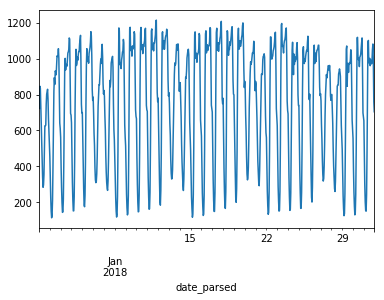

In [7]:
mean_trafic.loc['2018-01-01':'2018-01-31', 'debit'].plot()

There are several ways to remove such periodic trends from the data. We could for example average traffic across days or weeks and then subtract the average from the original series. Alternatively, we could try to fit a model for such oscillations. Finally, we could use frequency domain analysis (Fast fourier transform) to zero-out the coefficients related to the oscillations. Here, we will instead calculate a moving average over the time series with the length of the window of 7 days. This way we will effectively average out any weekly/daily fluctuations.

In [8]:
trafic_ma_7days = mean_trafic.loc[:, ['debit', 'percent']].rolling('7D').mean()

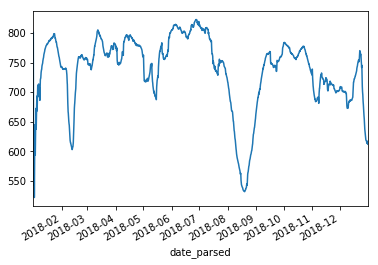

In [9]:
trafic_ma_7days.loc['2018-01-01':'2018-12-31', 'debit'].plot()

## Pollution data

We obtain the pollution data from Airparif service in GeoJSON format. As previously we use geopandas to import the data. However, this time we will use the name of the location (Paris, 4th arrendisement) to select the measurement station.

https://data-airparif-asso.opendata.arcgis.com/datasets/814f8e1550db4852b2c0a79f23c66f9c_0?geometry=2.326%2C48.858%2C2.357%2C48.863&selectedAttribute=date_debut

In [10]:

gdf = gpd.read_file('./data/airparif_2018/airparis.geojson')


In [11]:
paris_center = gdf[gdf['nom_com'] == 'PARIS-4E-ARRONDISSEMENT']

In [12]:
paris_center.head()

,id,nom_dept,nom_com,id_com,nom_station,code_station_ue,typologie,nom_poll,id_poll_ue,valeur,unite,metrique,date_debut,date_fin,statut_valid,x,y,geometry
40541,50542,PARIS,PARIS-4E-ARRONDISSEMENT,75104,PARIS Centre,4143,Urbaine,NO2,8,38.0,ug.m-3,horaire,2017-09-18T16:00:00,2017-09-18T17:00:00,1,652382,6862336,POINT (2.35098445380465 48.85929729959835)
40542,50543,PARIS,PARIS-4E-ARRONDISSEMENT,75104,PARIS Centre,4143,Urbaine,NO2,8,37.0,ug.m-3,horaire,2017-09-18T17:00:00,2017-09-18T18:00:00,1,652382,6862336,POINT (2.35098445380465 48.85929729959835)
40543,50544,PARIS,PARIS-4E-ARRONDISSEMENT,75104,PARIS Centre,4143,Urbaine,NO2,8,44.0,ug.m-3,horaire,2017-09-18T18:00:00,2017-09-18T19:00:00,1,652382,6862336,POINT (2.35098445380465 48.85929729959835)
40544,50545,PARIS,PARIS-4E-ARRONDISSEMENT,75104,PARIS Centre,4143,Urbaine,NO2,8,67.0,ug.m-3,horaire,2017-09-18T19:00:00,2017-09-18T20:00:00,1,652382,6862336,POINT (2.35098445380465 48.85929729959835)
40545,50546,PARIS,PARIS-4E-ARRONDISSEMENT,75104,PARIS Centre,4143,Urbaine,NO2,8,74.0,ug.m-3,horaire,2017-09-18T20:00:00,2017-09-18T21:00:00,1,652382,6862336,POINT (2.35098445380465 48.85929729959835)


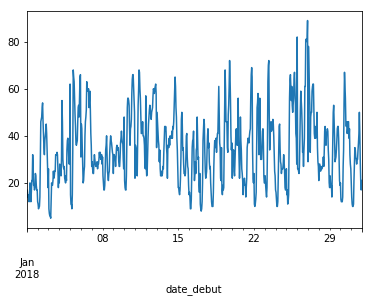

In [13]:

paris_center = paris_center.set_index(pd.to_datetime(paris_center['date_debut']))
paris_center.sort_index(inplace=True)
paris_center.loc['2018-01-01':'2018-01-31', 'valeur'].plot()

Since the traffic and pollution data are not given with the same frequency, we need to reample the pollution indicators with the resolution of 1 hours. We will do that using the `resample` method of pandas but before doing it, we have to make sure that each timestamp appears not more than once. To do that, we average the sensor readings obtained from the same timestamp.

In [14]:
no2_values = (paris_center.valeur
                .groupby(paris_center.index)
                .mean()
                .resample('1H')
                .mean()
                .fillna(method='ffill'))

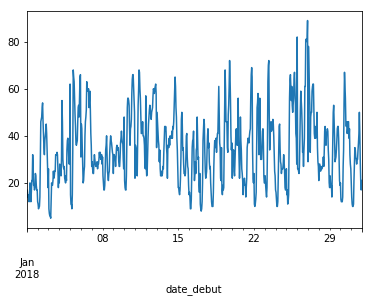

In [15]:
no2_values.loc['2018-01-01':'2018-01-31'].plot()

Finally, we calculate the moving average with a 7-day window similarly to what we did for the traffic data.

In [16]:
no2_ma_7days = no2_values.rolling('7D').mean()
no2_ma_7days = no2_ma_7days.loc['2018-01-01':'2018-12-31']

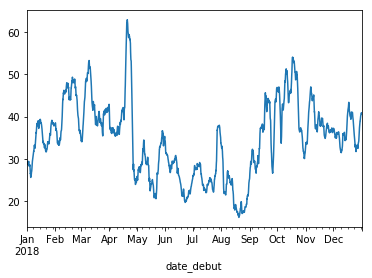

In [17]:
no2_ma_7days.plot()

## Regression

Now we can build a regression model. To do that we will first merge the traffic and pollution data into a single data frame. We then can use the statsmodels library to fit a linear model. The advantage of this approach compared to for example `scikit-learn` is that we also obtain statistical information on top of the fitted parameters. To define a model, we can use a very flexible mini-language (called `patsy` in Python) that allows for definition of dependent and independent variables and interactions between. Our linear model is very simple with a single independent (traffic) and dependent variable (concentration of NO$_2$ in the atmosphere).

In [18]:
combined_data = pd.concat({'trafic':trafic_ma_7days.debit,
                           'no2' : no2_ma_7days}, axis=1).dropna()
combined_data = combined_data.loc['2018-01-01':'2018-12-31']
combined_data.head()

,no2,trafic
2018-01-01 01:00:00,29.196429,723.543040
2018-01-01 02:00:00,29.178571,785.135623
2018-01-01 03:00:00,29.184524,801.617949
2018-01-01 04:00:00,29.166667,784.571337
2018-01-01 05:00:00,29.160714,753.199890


In [19]:
from statsmodels.formula.api import ols


model = ols('no2~trafic',combined_data)
res = model.fit()

res.params

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    no2   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     670.8
Date:                Fri, 15 Mar 2019   Prob (F-statistic):          1.41e-142
Time:                        18:03:58   Log-Likelihood:                -31251.
No. Observations:                8756   AIC:                         6.251e+04
Df Residuals:                    8754   BIC:                         6.252e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9091      1.114      5.306      0.000       3.726       8.092
trafic         0.0390      0.002     25.900      0.000       0.036       0.042
==============================================================================
Omnibus:                      146.080   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.803
Skew:                           0.228   Prob(JB):                     1.31e-27
Kurtosis:                       2.638   Cond. No.                     8.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The summary tables contains a lot of useful diagnostics about the model. We will focus here on the `R-squared` value that is also often called explained variance. The value of 0.063 means that the traffic can explain only 6% of the variance (i.e. fluctuations) in the NO$_2$ concentrations. When we plot the residuals we can see that there is still some periodic trend, that may be related to the seasons. Therefore, we can try to factor the seasons in the model. For this we will insert a categorical column into our dataframe (`season`) that will simply contain the name of the season for each measurment date. We then extend the model with the seasons, which is as simple as adding an extra independent variable. `statsmodels` will automatically deal with the fact that it's a categorical variable and convert it to the format suitable for linear regression.

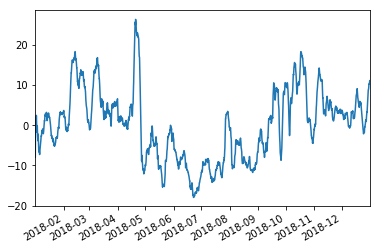

In [20]:
res.resid.plot()

In [21]:
combined_data.loc['2018-01-01':'2018-03-19','seasons'] = 'winter'
combined_data.loc['2018-03-20':'2018-06-20', 'seasons'] = 'spring'
combined_data.loc['2018-06-20':'2018-09-21', 'seasons'] = 'summer'
combined_data.loc['2018-09-22':'2018-12-20', 'seasons'] = 'autumn'
combined_data.loc['2018-12-21':'2018-12-31', 'seasons'] = 'winter'

In [22]:
combined_data.head()

,no2,trafic,seasons
2018-01-01 01:00:00,29.196429,723.543040,winter
2018-01-01 02:00:00,29.178571,785.135623,winter
2018-01-01 03:00:00,29.184524,801.617949,winter
2018-01-01 04:00:00,29.166667,784.571337,winter
2018-01-01 05:00:00,29.160714,753.199890,winter


In [23]:
from statsmodels.formula.api import ols


model = ols('no2~trafic+seasons',combined_data)
res = model.fit()

res.params

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    no2   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     1515.
Date:                Fri, 15 Mar 2019   Prob (F-statistic):               0.00
Time:                        18:03:58   Log-Likelihood:                -29271.
No. Observations:                8756   AIC:                         5.855e+04
Df Residuals:                    8751   BIC:                         5.859e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            15.3450      0.949     16.177      0.000      13.486      17.204
seasons[T.spring]    -7.2384      0.213    -33.925      0.000      -7.657      -6.820
seasons[T.summer]   -12.7965      0.208    -61.612      0.000     -13.204     -12.389
seasons[T.winter]    -0.9529      0.209     -4.557      0.000      -1.363      -0.543
trafic                0.0334      0.001     26.113      0.000       0.031       0.036
==============================================================================
Omnibus:                     1195.034   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1993.028
Skew:                           0.925   Prob(JB):                         0.00
Kurtosis:                       4.430   Cond. No.                     9.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There are two suprising elements hidden in the summary table of our extended model. First, we see not one but four extra variables (called `seasons[T.spring]` and similar for other seasons). This is because `statsmodels` converts the categorical data into an indicator variables, one per each label (minus one which can be inferred from other indicators, i.e. if it's not spring, nor summer, nor winter, it must be autumn). Secondly, the `R-squared` value increased from 0.06 to 0.41, which means that we can explain 35% more with the season information than with the traffic data alone. Of course, it does not mean that the seasons cause pollution, but rather that there are some climatic factors that are linked to the season, which may affect the concentration of pollutants in the atmosphere. For example, it's a well-known fact that wind will transport the pollution out of the city.

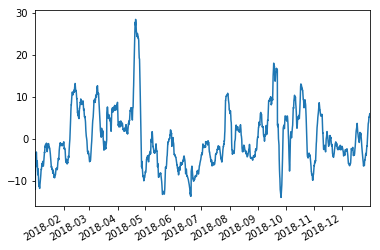

In [24]:
res.resid.plot()